In [1]:
# Adapted from SageMaker Immersion Day
# Source: https://catalog.us-east-1.prod.workshops.aws/workshops/63069e26-921c-4ce1-9cc7-dd882ff62575/en-US
# License: MIT License

#  Customer Churn Prediction with Amazon SageMaker XGBoost


## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data exploration](#DataExploration)
1. [Data Preparation](#DataPreparation)
1. [Training](#Training)
1. [Model Deployment](#ModelDeployment)
1. [Model Prediction and Evaluation](#ModelPredictionAndEvaluation)


---

## Background
This is my first SageMaker project where I plan to learn the whole ML cycle which will include the following:  

* Downloading data from the Kaggle into Amazon SageMaker
* EDA - exploratary data analysis 
* Transformation of the data to fit Amazon SageMaker algorithms
* Develop the model using the Gradient Boosting algorithm
* Evaluation the effectiveness of the model
* Model deployment
* Endpoint validation

---





## Setup

In [3]:
!pip install kaggle

  Using cached kaggle-1.5.13-py3-none-any.whl
  Using cached python_slugify-8.0.1-py2.py3-none-any.whl (9.7 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)


In [2]:
#Set up Kaggle API
!mv ./kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

mv: cannot stat './kaggle.json': No such file or directory


In [2]:
#Import libraries

import numpy as np
import pandas as pd 
import matplotlib.ticker as mtick 
import matplotlib.pyplot as plt
import seaborn as sns 

from time import gmtime, strftime
import json
import os
import zipfile

import sagemaker
from sagemaker import get_execution_role
import boto3
import re


sns.set(style = 'white')
%matplotlib inline



In [3]:
bucket=sagemaker.Session().default_bucket()
prefix='sagemaker/xgbootst-dm'



In [4]:
# Import or install the Data Wrangler widget to show automatic visualization and generate code to fix data quality issues

try:
    import sagemaker_datawrangler
except ImportError:
    !pip install --upgrade sagemaker-datawrangler
    import sagemaker_datawrangler

In [7]:
#download the dataset from kaggle and unzip it
!kaggle datasets download -d blastchar/telco-customer-churn --unzip

/bin/bash: kaggle: command not found


### DataExploration
Let us first start with exploring our data set, to better understand the patterns in the data and potentially form some hypothesis. First we will look at the distribution of individual variables and then slice and dice our data for any interesting trends.

In [5]:
df = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('display.max_columns', 500) 
df.head()

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No        

Data Wrangler provided a quick overview of all features with the suggestion to drop some columns that looked like ID or had one unique value.<br>
Let's follow the recommendation and drop these columns, but we will keep MonthlyCharges and TotalCharges column because they potentially may impact churn rate.

In [6]:
df = df.drop(['customerID','Dependents','StreamingTV','StreamingMovies'], axis = 1)

In [7]:
# Checking the data types of all the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   tenure            7043 non-null   int64  
 4   PhoneService      7043 non-null   object 
 5   MultipleLines     7043 non-null   object 
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  Contract          7043 non-null   object 
 12  PaperlessBilling  7043 non-null   object 
 13  PaymentMethod     7043 non-null   object 
 14  MonthlyCharges    7043 non-null   float64
 15  TotalCharges      7043 non-null   object 
 16  Churn             7043 non-null   object 


In [11]:
df.shape

(7043, 17)

In [8]:
# Converting Total Charges to a numerical data type.
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
#Removing missing values 
df.dropna(inplace = True)

In [10]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

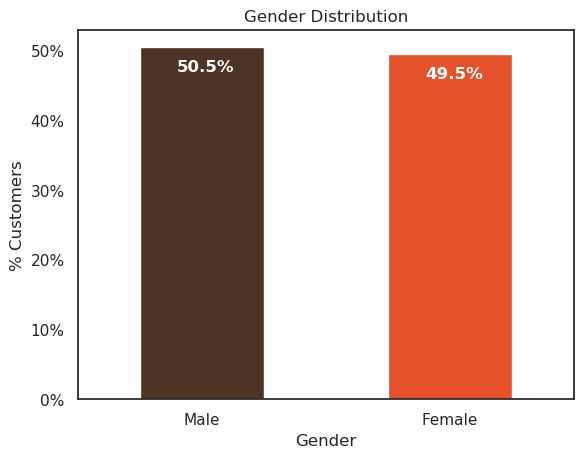

In [11]:
#Gender Distribution - About half of the customers in our data set are male while the other half are female

colors = ['#4D3425','#E4512B']
ax = (df['gender'].value_counts()*100.0 /len(df)).plot(kind='bar',
                                                                           stacked = True,
                                                                          rot = 0,
                                                                          color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers')
ax.set_xlabel('Gender')
ax.set_ylabel('% Customers')
ax.set_title('Gender Distribution')

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-3.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold')

Text(0.5, 1.0, '% of Senior Citizens')

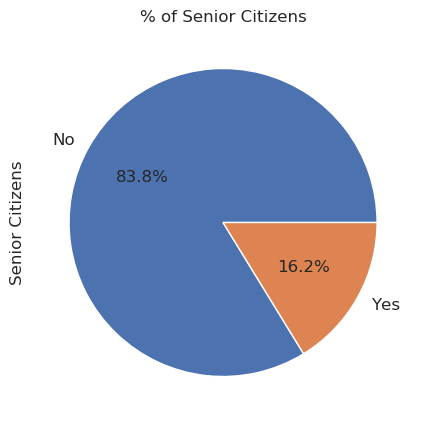

In [12]:
# % Senior Citizens - There are only 16% of the customers who are senior citizens. Thus most of our customers in the data are younger people.

ax = (df['SeniorCitizen'].value_counts()*100.0 /len(df))\
.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Senior Citizens',fontsize = 12)
ax.set_title('% of Senior Citizens', fontsize = 12)

Text(0.5, 1.0, '# of Customers by their tenure')

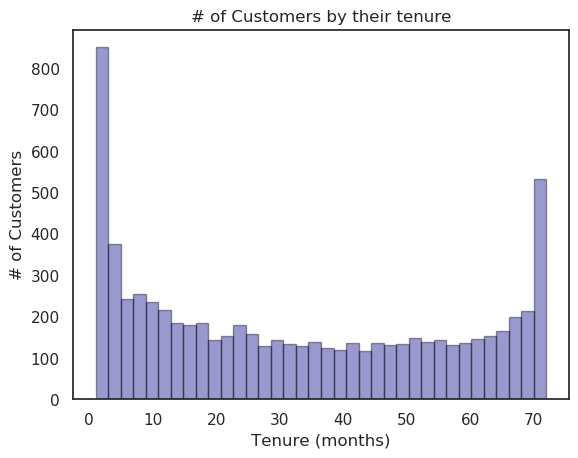

In [13]:
#Tenure: There are a lot of customers have been with the telecom company for just a month, while quite a many are there for about 72 months. 

ax = sns.distplot(df['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('# of Customers by their tenure')

Text(0.5, 1.0, '# of Customers by Contract Type')

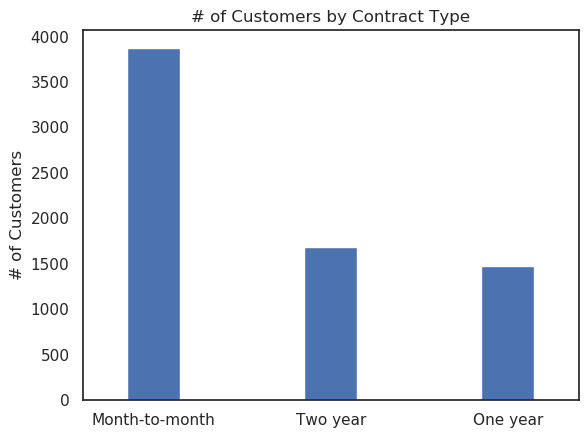

In [14]:
# Number of customers by different contracts.
ax = df['Contract'].value_counts().plot(kind = 'bar',rot = 0, width = 0.3)
ax.set_ylabel('# of Customers')
ax.set_title('# of Customers by Contract Type')

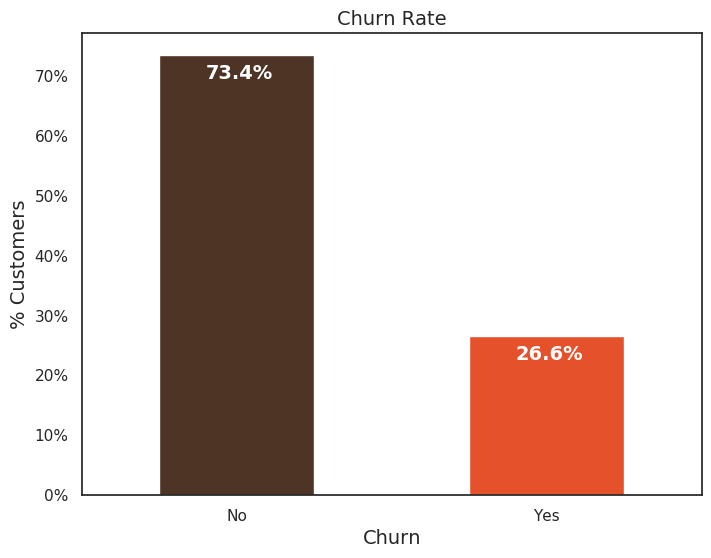

In [15]:
# The below is the Churn distribution

colors = ['#4D3425','#E4512B']
ax = (df['Churn'].value_counts()*100.0 /len(df)).plot(kind='bar', stacked = True, rot = 0, color = colors, figsize = (8,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Customers',size = 14)
ax.set_xlabel('Churn',size = 14)
ax.set_title('Churn Rate', size = 14)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_x()+.15, i.get_height()-4.0, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
           weight = 'bold',
           size = 14)

## DataPreparation

Before we train the model, let's prepare the data

In [16]:
#Convertin the predictor variable in a binary numeric variable
df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [17]:
#Convert all the categorical variables into dummy variables
model_data = pd.get_dummies(df)
model_data.head()

   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Female  \
0              0       1           29.85         29.85      0              1   
1              0      34           56.95       1889.50      0              0   
2              0       2           53.85        108.15      1              0   
3              0      45           42.30       1840.75      0              0   
4              0       2           70.70        151.65      1              1   

   gender_Male  Partner_No  Partner_Yes  PhoneService_No  PhoneService_Yes  \
0            0           0            1                1                 0   
1            1           1            0                0                 1   
2            1           1            0                0                 1   
3            1           1            0                1                 0   
4            0           1            0                0                 1   

   MultipleLines_No  MultipleLines_No phone servic

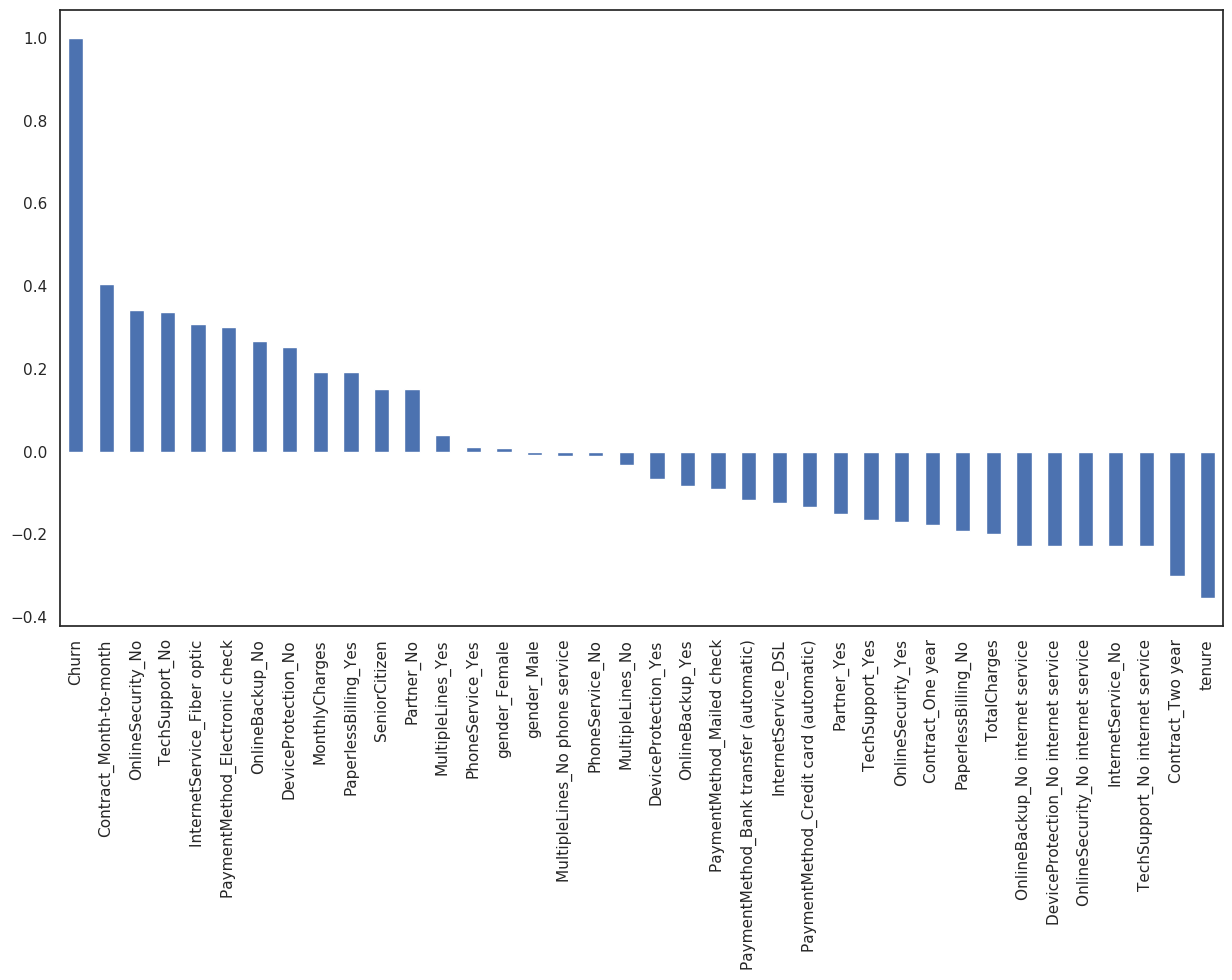

In [18]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(15,8))
model_data.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

Month to month contracts, absence of online security and tech support seem to be positively correlated with churn. <br> While, tenure, two year contracts seem to be negatively correlated with churn.

In [19]:
# Let's drop features that are less correlated

model_data = model_data.drop(['MultipleLines_No','MultipleLines_Yes','PhoneService_No','PhoneService_Yes','gender_Female','gender_Male'], axis = 1)

## Training

After data is prepared it is time to train the model.

In [20]:
# Let's split the data set into 3 channels: train, test, validation set:
train_data,validation_data,test_data=np.split(model_data.sample(frac=1, random_state=1729),[int(0.7*len(model_data)),int(0.9*len(model_data))])

In [21]:
# Amazon SageMaker XGBoost algorithm expects data to be in libSVM or CSV format (without header) and the first column must be the target variable. So in this step we transform the data accordingly
pd.concat([train_data['Churn'],train_data.drop(['Churn'],axis=1)],axis=1).to_csv('train.csv',index=False,header=False)
pd.concat([validation_data['Churn'],validation_data.drop(['Churn'],axis=1)],axis=1).to_csv('validation.csv',index=False,header=False)

In [22]:
# Upload train and validation files to S3 bucket
boto3.Session().resource ('s3').Bucket(bucket).Object(os.path.join(prefix,'train/train.csv')).upload_file('train.csv')
boto3.Session().resource ('s3').Bucket(bucket).Object(os.path.join(prefix,'validation/validation.csv')).upload_file('validation.csv')

In [23]:
role=get_execution_role()

In [24]:
# Specify XGBoost ECR container 
container=sagemaker.image_uris.retrieve(region=boto3.Session().region_name,framework='xgboost',version='latest')

In [25]:
s3_input_train=sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket,prefix),content_type='csv')
s3_input_validation=sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation'.format(bucket,prefix),content_type='csv')

In [26]:
#Set-up hyperparameters and fit the train data
sess=sagemaker.Session()
xgb=sagemaker.estimator.Estimator(container,role,instance_count=1,instance_type='ml.m4.xlarge',
                                 output_path='s3://{}/{}/output'.format(bucket,prefix), sagemaker_session=sess)

xgb.set_hyperparameters(max_depth=5, eta=0.2, gamma=4, min_child_weight=6, subsample=0.8, silent=0, objective='binary:logistic',num_round=100)

xgb.fit({'train':s3_input_train,'validation':s3_input_validation})

2023-07-17 22:15:13 Starting - Starting the training job...
2023-07-17 22:15:38 Starting - Preparing the instances for training......
2023-07-17 22:16:36 Downloading - Downloading input data...
2023-07-17 22:17:06 Training - Downloading the training image......
2023-07-17 22:18:12 Uploading - Uploading generated training modelArguments: train
[2023-07-17:22:18:05:INFO] Running standalone xgboost training.
[2023-07-17:22:18:05:INFO] File size need to be processed in the node: 0.44mb. Available memory size in the node: 8580.3mb
[2023-07-17:22:18:05:INFO] Determined delimiter of CSV input is ','
[22:18:05] S3DistributionType set as FullyReplicated
[22:18:05] 4922x31 matrix with 152582 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-07-17:22:18:05:INFO] Determined delimiter of CSV input is ','
[22:18:05] S3DistributionType set as FullyReplicated
[22:18:05] 1406x31 matrix with 43586 entries loaded from /opt/ml/input/data/validation?format=csv&label_c

## ModelDeployement

The model was deployed on one M4.XLARGE instance

In [27]:
xgb_predictor=xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

-----!

### Model Prediction and Evaluation

In [28]:
xgb_predictor.serializer=sagemaker.serializers.CSVSerializer()

In [31]:
def predict (data,predictor, rows=500):
    split_array=np.array_split(data,int(data.shape[0]/float(rows)+1))
    predictions=''
    for array in split_array:
        predictions=','.join([predictions,predictor.predict(array).decode('utf-8')])
        
    return np.fromstring(predictions[1:],sep=',')

predictions=predict(test_data.drop(['Churn'],axis=1).to_numpy(),xgb_predictor)

In [33]:
pd.crosstab(index=test_data['Churn'],columns=np.round(predictions),rownames=['actuals'],colnames=['predictions'])

predictions  0.0  1.0
actuals              
0            479   48
1             88   89

So, out of 704 customers, model predicted 137 would churn and 89 of them actually did. We also had 88 customer who actually churned but model did not predict that. <br>
There are some space for improvement like hyperparameters tuning, different model selection, models ensemble, and feature engineering

In [34]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)